# Intro 

This file does some mild explaration of the MIMIC-III dataset ***AFTER*** we have done feature selection.

## Imports
Please specify the correct path to the MIMIC-III repository in the cell below.

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

MIMIC3_dir = "C:/Users/Jonas/Dropbox/DTU/Semester6/Specialkurser/Neural Networks and Logic/code/mimic3-benchmarks-1.0.0-alpha"
sys.path.append(MIMIC3_dir)

from mimic3benchmark.readers import InHospitalMortalityReader
from mimic3models.in_hospital_mortality import utils
from mimic3models import common_utils

## Loading the data

In [2]:
def read_and_extract_features(reader):
    ret = common_utils.read_chunk(reader, reader.get_number_of_examples())
    period, features = 'all', 'all'

    X = common_utils.extract_features_from_rawdata(ret['X'], ret['header'], period, features)
    return X, ret

In [3]:
reader = InHospitalMortalityReader(dataset_dir=os.path.join("data/in-hospital-mortality/train"), period_length=48.0)
(X_features, raw) = read_and_extract_features(reader)

In [4]:
headers = np.array(raw['header'][1:])
y = np.array([raw['y']])

### Reshape the data

The data is reshaped into a MultiIndex DataFrame.
This means we can index over headers, sequences and statistics, and thus the data will be easier to work with.

In [5]:
# Create the column headers for the featurs.
sample_stats = ['min', 'max', 'mean', 'std', 'skew', 'len']
subsequences = ['all', 'first10', 'first25', 'first50', 'last10', 'last25', 'last50']
tuples = [(header, subsequence, stat) for header in headers for subsequence in subsequences for stat in sample_stats]

# Append the y-values
tuples.append(('y', '', ''))
data = np.concatenate((X_features, y.T), axis=1)

# create index and dataframe
index = pd.MultiIndex.from_tuples(tuples, names=["header", "sequence", "stat"])
df = pd.DataFrame(data, columns=index)

Inspect the DataFrame

In [6]:
df

header   Capillary refill rate                                             \
sequence                   all                       first10                
stat                       min max mean std skew len     min max mean std   
0                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
1                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
2                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
3                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
4                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
...                        ...  ..  ...  ..  ...  ..     ...  ..  ...  ..   
17898                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17899                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17900                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17901                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17902                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   

header    ...        pH                                                      \
sequence  ...    last25                    last50                             
stat      ...       std          skew  len    min   max      mean       std   
0         ...  0.000000  0.000000e+00  1.0   5.00  5.00  5.000000  0.000000   
1         ...  0.004714 -7.071068e-01  3.0   7.37  7.38  7.376667  0.004714   
2         ...  0.000000  0.000000e+00  1.0   7.40  7.44  7.426667  0.018856   
3         ...  0.000000  0.000000e+00  1.0   7.41  7.49  7.450000  0.040000   
4         ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
...       ...       ...           ...  ...    ...   ...       ...       ...   
17898     ...  1.164484 -7.064811e-01  3.0   5.00  7.49  6.807500  1.046240   
17899     ...  0.000000  0.000000e+00  1.0   7.50  7.50  7.500000  0.000000   
17900     ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
17901     ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
17902     ...  0.015000 -8.884434e-14  2.0   7.33  7.38  7.360000  0.016330   

header                     y  
sequence                      
stat          skew  len       
0         0.000000  1.0  0.0  
1        -0.707107  3.0  0.0  
2        -0.707107  3.0  0.0  
3         0.000000  2.0  0.0  
4              NaN  NaN  1.0  
...            ...  ...  ...  
17898    -1.137264  4.0  0.0  
17899     0.000000  1.0  0.0  
17900          NaN  NaN  0.0  
17901          NaN  NaN  0.0  
17902    -0.688919  6.0  0.0  

[17903 rows x 715 columns]

To index this DataFrame, we need a pandas.IndexSlice

In [161]:
idx = pd.IndexSlice

# Data Exploration

First, we check the amount of data and the data types:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17903 entries, 0 to 17902
Columns: 715 entries, ('Capillary refill rate', 'all', 'min') to ('y', '', '')
dtypes: float64(715)
memory usage: 97.7 MB


Because all values are floats, we can dig straight in.

### Data split
Check the number of mortalities

In [387]:
gt0 = np.sum(df.loc[:, idx['y']].gt(0))
eq0 = df.shape[0] - gt0

print(f"Mortalities: {gt0}. Survivors: {eq0}. Mortality rate: {round(gt0/eq0 * 100, 3)}%.")

Mortalities: 2423. Survivors: 15480. Mortality rate: 15.652%.


## Pairwise Relationships (correlations)

In the following, we will restict ourselves to the *mean* values over the *entire 48 hours of initial stay* in the ICU.

In [154]:
data = df.loc[:, idx[:, ('all', ''), ('mean', '')]].droplevel(['sequence', 'stat'], axis=1)

Then, we check the correlations among variables:

In [176]:
corr = data.corr()
corr

header,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,y
header,,,,,,,,,,,,,,,,,,
Capillary refill rate,1.000000,-0.169433,-0.420431,-0.189948,-0.210028,-0.233095,-0.229527,0.055780,0.033841,NaN,-0.202094,-0.224188,0.044778,-0.178472,-0.023248,-0.037437,0.044539,0.237187
Diastolic blood pressure,-0.169433,1.000000,-0.031745,-0.020401,-0.000603,-0.060781,-0.011734,-0.001408,0.078958,0.001504,0.142882,0.003360,0.003117,0.170881,0.006164,-0.001301,-0.001516,-0.012010
Fraction inspired oxygen,-0.420431,-0.031745,1.000000,0.078678,-0.000773,0.052592,0.224055,-0.007213,0.067589,0.029072,-0.028681,0.038571,-0.004232,-0.147618,0.007345,-0.009217,-0.015512,0.078559
Glascow coma scale eye opening,-0.189948,-0.020401,0.078678,1.000000,0.825326,0.933595,0.770459,-0.012564,-0.057284,-0.047781,-0.037568,0.004642,0.003451,-0.023919,-0.047279,-0.004723,-0.043331,-0.314576
Glascow coma scale motor response,-0.210028,-0.000603,-0.000773,0.825326,1.000000,0.875041,0.655755,-0.008084,-0.079434,-0.041219,-0.011675,0.004254,-0.003395,0.038037,-0.030089,0.000905,-0.037761,-0.318425
Glascow coma scale total,-0.233095,-0.060781,0.052592,0.933595,0.875041,1.000000,0.924772,-0.067828,-0.117992,-0.443803,-0.057942,-0.098377,0.093064,0.002266,-0.259680,-0.050854,-0.023537,-0.327745
Glascow coma scale verbal response,-0.229527,-0.011734,0.224055,0.770459,0.655755,0.924772,1.000000,-0.015014,-0.060339,-0.040436,-0.038554,0.005313,-0.006908,-0.022944,-0.059884,-0.006597,-0.052816,-0.250962
Glucose,0.055780,-0.001408,-0.007213,-0.012564,-0.008084,-0.067828,-0.015014,1.000000,-0.003932,0.003775,0.003773,-0.000535,-0.000639,0.015302,-0.000710,-0.000248,0.000382,0.004718
Heart Rate,0.033841,0.078958,0.067589,-0.057284,-0.079434,-0.117992,-0.060339,-0.003932,1.000000,-0.027224,0.056890,-0.006959,-0.000233,-0.125440,0.052613,0.001207,-0.006837,0.089596


Now, this table is **HUGE**.

Let's restrict ourselves and look at the 5 variables that has the highes correlation with our y-variable.

In [178]:
corr_idx =corr.loc[:, 'y'].abs().nlargest(6).keys()
corr.loc[corr_idx, corr_idx]

header,y,Glascow coma scale total,Glascow coma scale motor response,Glascow coma scale eye opening,Glascow coma scale verbal response,Capillary refill rate
header,,,,,,
y,1.000000,-0.327745,-0.318425,-0.314576,-0.250962,0.237187
Glascow coma scale total,-0.327745,1.000000,0.875041,0.933595,0.924772,-0.233095
Glascow coma scale motor response,-0.318425,0.875041,1.000000,0.825326,0.655755,-0.210028
Glascow coma scale eye opening,-0.314576,0.933595,0.825326,1.000000,0.770459,-0.189948
Glascow coma scale verbal response,-0.250962,0.924772,0.655755,0.770459,1.000000,-0.229527
Capillary refill rate,0.237187,-0.233095,-0.210028,-0.189948,-0.229527,1.000000


Clearly, the GCS variable is interesting. 

BUT, let's only look at the glasgow coma scale total, and ignore the others.

So, drop the others and repeat computation.

In [185]:
corr_new = data.drop(corr.columns[[3, 4, 6]], axis=1).corr()
corr_new_idx = corr_new.loc[:, 'y'].abs().nlargest(6).keys()
corr_new.loc[corr_new_idx, corr_new_idx]

header,y,Glascow coma scale total,Capillary refill rate,Heart Rate,Systolic blood pressure,Fraction inspired oxygen
header,,,,,,
y,1.000000,-0.327745,0.237187,0.089596,-0.080551,0.078559
Glascow coma scale total,-0.327745,1.000000,-0.233095,-0.117992,0.002266,0.052592
Capillary refill rate,0.237187,-0.233095,1.000000,0.033841,-0.178472,-0.420431
Heart Rate,0.089596,-0.117992,0.033841,1.000000,-0.125440,0.067589
Systolic blood pressure,-0.080551,0.002266,-0.178472,-0.125440,1.000000,-0.147618
Fraction inspired oxygen,0.078559,0.052592,-0.420431,0.067589,-0.147618,1.000000


### Let's plot it! 

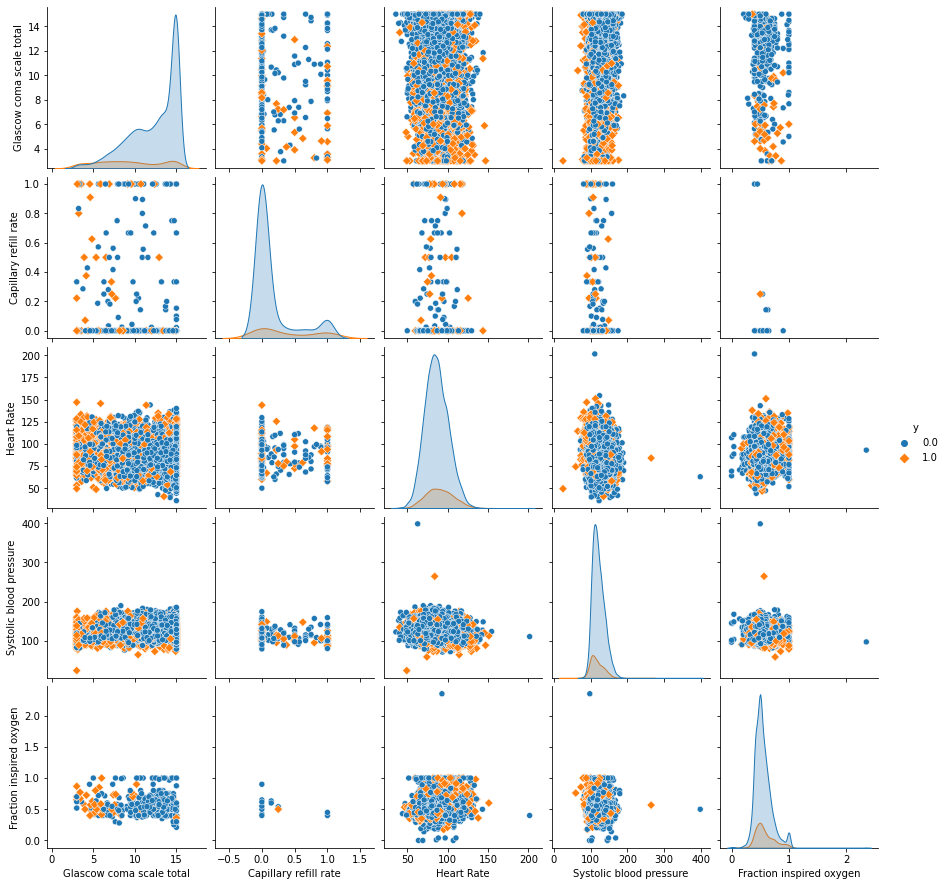

In [190]:
sns.pairplot(data, vars=corr_new_idx[1:], hue='y', markers=["o", "D"])

Let's have a closer look at some selected variables:

## Glasgow Coma Scale 

Let's check which statistics leads to highest correlation:

In [395]:
data = df.loc[:, idx[('Glascow coma scale total', 'y'), ('all', ''), :]].droplevel(['header', 'sequence'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

stat,min,max,mean,std,skew,len,y
stat,,,,,,,
min,1.000000,0.449967,0.756073,-0.802390,0.017238,-0.113455,-0.156766
max,0.449967,1.000000,0.829647,0.110193,-0.197860,-0.149057,-0.346919
mean,0.756073,0.829647,1.000000,-0.338238,-0.357842,-0.156807,-0.327745
std,-0.802390,0.110193,-0.338238,1.000000,-0.079836,-0.021638,-0.037443
skew,0.017238,-0.197860,-0.357842,-0.079836,1.000000,-0.043522,0.147594
len,-0.113455,-0.149057,-0.156807,-0.021638,-0.043522,1.000000,0.058161
y,-0.156766,-0.346919,-0.327745,-0.037443,0.147594,0.058161,1.000000


Likewise, we can check the different periods:

In [405]:
data = df.loc[:, idx[('Glascow coma scale total', 'y'), :, ('max', '')]].droplevel(['header', 'stat'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

sequence,all,first10,first25,first50,last10,last25,last50,y
sequence,,,,,,,,
all,1.000000,0.591373,0.734834,0.874518,0.825354,0.852712,0.887973,-0.346919
first10,0.591373,1.000000,0.850533,0.706973,0.442203,0.457280,0.477609,-0.131015
first25,0.734834,0.850533,1.000000,0.854904,0.571018,0.589486,0.612504,-0.205898
first50,0.874518,0.706973,0.854904,1.000000,0.699802,0.718670,0.748323,-0.282026
last10,0.825354,0.442203,0.571018,0.699802,1.000000,0.969200,0.932298,-0.414897
last25,0.852712,0.457280,0.589486,0.718670,0.969200,1.000000,0.964147,-0.411348
last50,0.887973,0.477609,0.612504,0.748323,0.932298,0.964147,1.000000,-0.398707
y,-0.346919,-0.131015,-0.205898,-0.282026,-0.414897,-0.411348,-0.398707,1.000000


Let's plot some histograms!

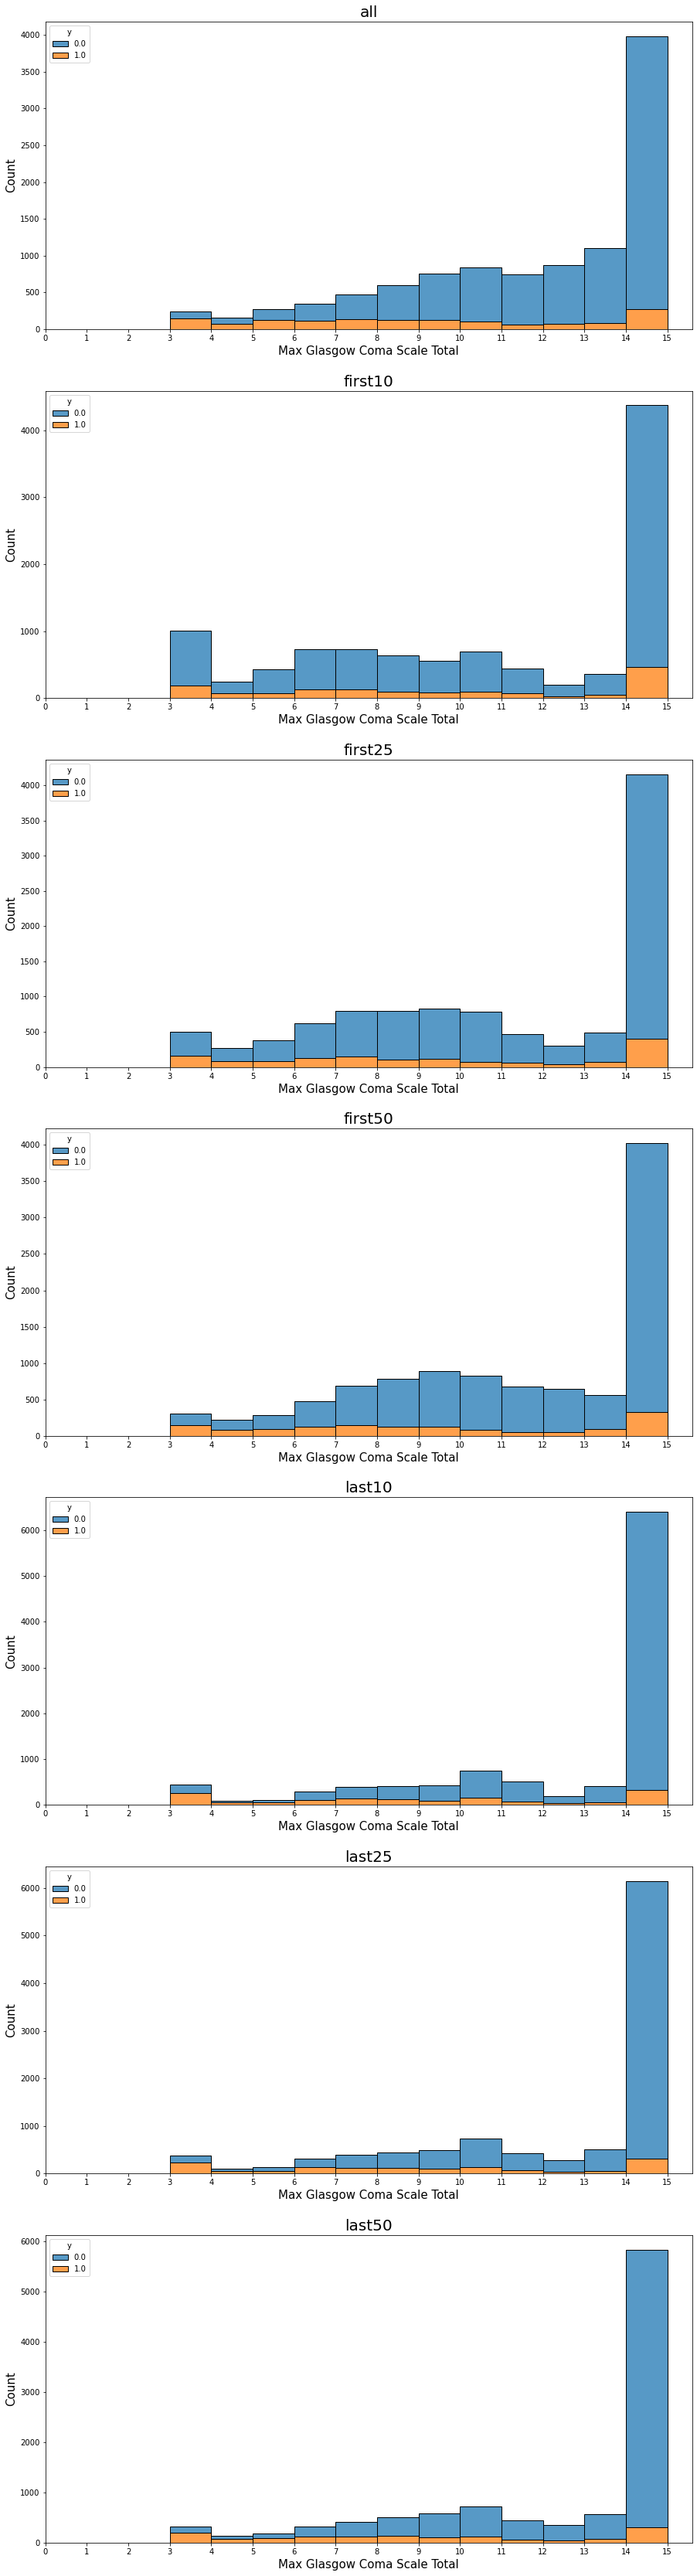

In [400]:
fig, axs = plt.subplots(nrows=7, figsize=(15,60))
fig.subplots_adjust(hspace=0.2)

for (i, seq) in enumerate(subsequences):
    g = sns.histplot(data=data, x=seq, bins=np.arange(3, 16), hue='y', multiple="stack", ax=axs[i])
    g.set_xticks(range(16))
    g.axes.set_title(f"{seq}",fontsize=20)
    g.set_xlabel("Max Glasgow Coma Scale Total",fontsize=15)
    g.set_ylabel("Count",fontsize=15)

## Capillary Refill Rate
We follow the same approach for the capillary refill rate, as we did for the glasgow coma scale.

In [366]:
data = df.loc[:, idx[('Capillary refill rate', 'y'), :, ('mean', '')]].droplevel(['header', 'stat'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

sequence,all,first10,first25,first50,last10,last25,last50,y
sequence,,,,,,,,
all,1.000000,0.848938,0.878167,0.931022,0.876115,0.876825,0.916000,0.237187
first10,0.848938,1.000000,0.980803,0.943879,0.590934,0.584711,0.631526,0.182278
first25,0.878167,0.980803,1.000000,0.969975,0.615782,0.611627,0.659040,0.189534
first50,0.931022,0.943879,0.969975,1.000000,0.691133,0.687608,0.736669,0.203769
last10,0.876115,0.590934,0.615782,0.691133,1.000000,0.995062,0.967949,0.242907
last25,0.876825,0.584711,0.611627,0.687608,0.995062,1.000000,0.972239,0.242473
last50,0.916000,0.631526,0.659040,0.736669,0.967949,0.972239,1.000000,0.236134
y,0.237187,0.182278,0.189534,0.203769,0.242907,0.242473,0.236134,1.000000


In [367]:
data = df.loc[:, idx[('Capillary refill rate', 'y'), ('all', ''), :]].droplevel(['header', 'sequence'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

stat,min,max,mean,std,skew,len,y
stat,,,,,,,
min,1.000000,0.532742,0.829846,-0.168620,-0.058883,-0.163912,0.206744
max,0.532742,1.000000,0.826359,0.716151,0.250082,-0.056747,0.205564
mean,0.829846,0.826359,1.000000,0.329549,-0.175554,-0.164269,0.237187
std,-0.168620,0.716151,0.329549,1.000000,0.168178,-0.006006,0.090098
skew,-0.058883,0.250082,-0.175554,0.168178,1.000000,0.239240,-0.037343
len,-0.163912,-0.056747,-0.164269,-0.006006,0.239240,1.000000,-0.148821
y,0.206744,0.205564,0.237187,0.090098,-0.037343,-0.148821,1.000000


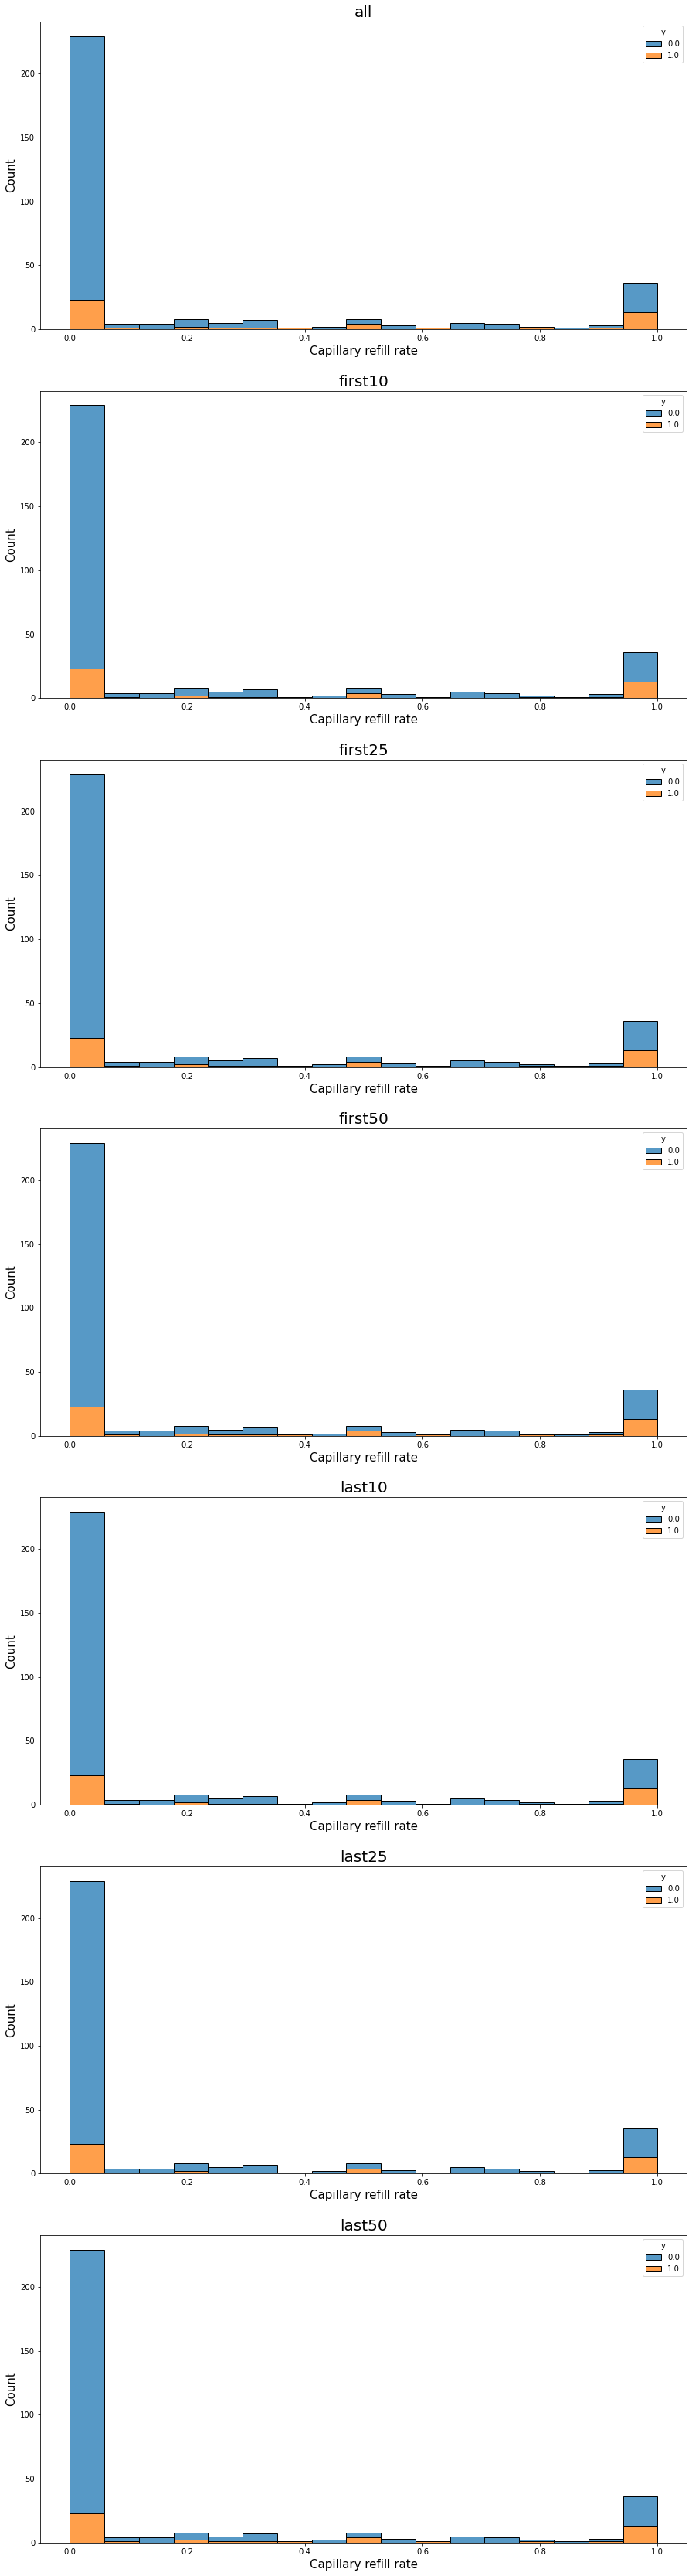

In [368]:
fig, axs = plt.subplots(nrows=7, figsize=(15,60))
fig.subplots_adjust(hspace=0.2)

for (i, seq) in enumerate(subsequences):
    g = sns.histplot(data=data, x=stat, hue='y', multiple="stack", ax=axs[i])
    g.axes.set_title(f"{seq}",fontsize=20)
    g.set_xlabel("Capillary refill rate",fontsize=15)
    g.set_ylabel("Count",fontsize=15)